# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, simulate_quant_trait
from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

from scipy.stats import t
from scipy import stats
from scipy.stats import entropy

from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from tensorflow.keras import Input, Model, layers, regularizers
from tensorflow.keras.layers import Input, Dense


2024-08-12 15:29:16.489660: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 15:29:16.612817: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 15:29:16.756490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 15:29:16.896779: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 15:29:16.904103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 15:29:17.112876: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
# Names of the environmental risks
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks",
    "gauss_blob_risk" : "Gaussian Risk",
    "three_square_risk": "Three localized Risks",
    "mid_mid_square_risk": "Mid square risk"
}

In [3]:
risks = list(naming_dict.keys())

In [4]:
# Load genotype

In [5]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [6]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [7]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
#very_rare = very_rare.iloc[::-1].reset_index(drop=True)
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

In [8]:
# Load population

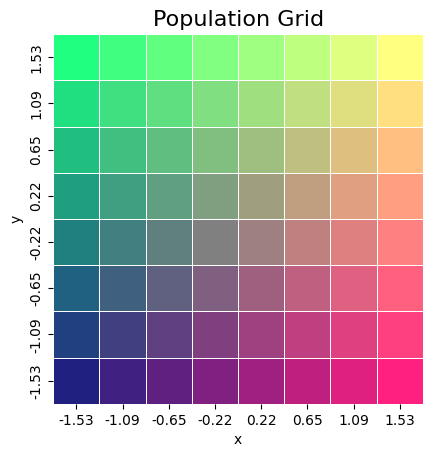

In [9]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

# Standardize the vector
std_dev = np.std(populations['x'])
mean = np.mean(populations['x'])
populations['x'] = np.round((populations['x'] - mean) / std_dev,2)

std_dev = np.std(populations['y'])
mean = np.mean(populations['y'])
populations['y'] = np.round((populations['y'] - mean) / std_dev,2)

# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')


heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

In [10]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")

In [11]:
true_p2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truep2.pkl")
true_twopqs = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truetwopq.pkl")
true_q2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_trueq2.pkl")

In [12]:
onehotpops = pd.get_dummies(populations[['populations']], columns=['populations']).astype(int)


In [13]:
def abyss(geno_in, geno_out, bottleneck_nr, epoch, patience):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(geno_in, geno_out, test_size=0.2, random_state=42)
    
    # Regularization parameter
    l2_regularizer = 0.001
    
    # Original autoencoder model with L2 regularization
    autoencoder = tf.keras.Sequential([
        tf.keras.layers.Dense(200, activation='elu', input_shape=(geno_in.shape[1],), kernel_regularizer=regularizers.l2(l2_regularizer)),  # First hidden layer with L2 regularization
        #layers.BatchNormalization(),
        #tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(bottleneck_nr, activation='elu', name='bottleneck', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Bottleneck layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(200, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Second hidden layer with L2 regularization
        #layers.BatchNormalization(),
        #tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(geno_out.shape[1], activation='linear', kernel_regularizer=regularizers.l2(l2_regularizer))  # Output layer
    ])
    
    # Compile the original model with L2 regularization
    autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['mean_absolute_error'])
    
    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Fit the original model with Early Stopping
    history = autoencoder.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Extract the bottleneck layer after fitting the model
    bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)
    
    return autoencoder, bottleneck_model, history

In [14]:
# visualise first
bottleneck_nr = 2
epoch = 200
patience = 10
dim_labels = [f"dim{i}" for i in range(1, bottleneck_nr + 1)]

In [15]:
# PCA
nr_common_PCs = 24
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
PC_common= pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [18]:
try:
    db_minor = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_minor.pkl")
    db_het = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_het.pkl")
    db_major = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_major.pkl")

except:
    # Create db_minor
    db_minor = complete.copy()
    db_minor = db_minor.applymap(lambda x: 1 if x == -1.0 else 0)
    
    # Create db_het
    db_het = complete.copy()
    db_het = db_het.applymap(lambda x: 1 if x == 0.0 else 0)
    
    # Create db_major
    db_major = complete.copy()
    db_major = db_major.applymap(lambda x: 1 if x == 1.0 else 0)
    
    db_minor.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_minor.pkl")
    db_het.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_het.pkl")
    db_major.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_major.pkl")

In [19]:
def abyss(geno_in, geno_out, bottleneck_nr, epoch, patience):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(geno_in, geno_out, test_size=0.2, random_state=42)
    
    # Regularization parameter
    l2_regularizer = 0.001
    
    # Original autoencoder model with L2 regularization
    autoencoder = tf.keras.Sequential([
        tf.keras.layers.Dense(200, activation='elu', input_shape=(geno_in.shape[1],), kernel_regularizer=regularizers.l2(l2_regularizer)),  # First hidden layer with L2 regularization
        #layers.BatchNormalization(),
        #tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(bottleneck_nr, activation='elu', name='bottleneck', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Bottleneck layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(200, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Second hidden layer with L2 regularization
        #layers.BatchNormalization(),
        #tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(geno_out.shape[1], activation='linear', kernel_regularizer=regularizers.l2(l2_regularizer))  # Output layer
    ])
    
    # Compile the original model with L2 regularization
    autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['mean_absolute_error'])
    
    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Fit the original model with Early Stopping
    history = autoencoder.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Extract the bottleneck layer after fitting the model
    bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)
    
    return autoencoder, bottleneck_model, history

# Function to ensure minimum cluster size
def ensure_min_cluster_size(data, labels, min_size):
    unique_labels, counts = np.unique(labels, return_counts=True)
    small_clusters = unique_labels[counts < min_size]
    
    # Reassign points from small clusters to the nearest large cluster
    for cluster in small_clusters:
        indices = np.where(labels == cluster)[0]
        for index in indices:
            # Find nearest large cluster
            nearest_large_cluster = None
            nearest_distance = float('inf')
            for label in unique_labels:
                if label not in small_clusters:
                    distance = np.linalg.norm(data.iloc[index] - kmeans.cluster_centers_[label])
                    if distance < nearest_distance:
                        nearest_distance = distance
                        nearest_large_cluster = label
            labels[index] = nearest_large_cluster
    
    return labels

In [ ]:
try:
    p2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_truep2_via_estimated_pop.pkl")
    twopq = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_true2pq_via_estimated_pop.pkl")
    q2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_trueq2_via_estimated_pop.pkl")

except:
    bottleneck_nr = 64
    epoch = 200
    patience = 10
    dim_labels = [f"dim{i}" for i in range(1, bottleneck_nr + 1)]
    autoencoder, bottleneck_model, history = abyss(complete, complete, bottleneck_nr, epoch, patience)
    bottle = pd.DataFrame(data=bottleneck_model(complete), columns = dim_labels)

    from sklearn.cluster import KMeans
    n_clusters = 120
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(bottle)
    
    # Step 3: Assign the cluster labels to each data point
    labels = kmeans.labels_
    
    # Step 4: Ensure minimum cluster size
    min_size = 10  # Set your desired minimum cluster size
    labels = ensure_min_cluster_size(bottle, labels, min_size)


    bottle['cluster'] = labels
    unique_pops = list(bottle['cluster'].unique())
    
    db_major['populations'] = bottle['cluster']
    db_het['populations'] = bottle['cluster']
    db_minor['populations'] = bottle['cluster']
    
    true_p2s['populations'] = bottle['cluster']
    true_twopqs['populations'] = bottle['cluster']
    true_q2s['populations'] = bottle['cluster']
    
    bottleneck_nr = 1
    dim_labels = [f"dim{i}" for i in range(1, bottleneck_nr + 1)]
    epoch = 500
    patience = 15
    p2s = []
    for pop in unique_pops:
        temp_major = db_major[db_major['populations'] == pop]
        temp_major.drop("populations", axis=1, inplace=True)
        autoencoder, bottleneck_model, history = abyss(temp_major, temp_major, bottleneck_nr, epoch, patience)
        p2 = autoencoder(tf.convert_to_tensor(temp_major, dtype=tf.float32))
        p2 = pd.DataFrame(data=p2, columns = complete.columns)
        p2.index = temp_major.index
        p2_bottle = pd.DataFrame(data=bottleneck_model(temp_major), columns = dim_labels)
        p2_bottle.index = temp_major.index
        p2s.append(p2)
    print("done with p2")
    
    twopqs = []
    for pop in unique_pops:
        temp_het = db_het[db_het['populations'] == pop]
        temp_het.drop("populations", axis=1, inplace=True)
        autoencoder, bottleneck_model, history = abyss(temp_het, temp_het, bottleneck_nr, epoch, patience)
        twopq = autoencoder(tf.convert_to_tensor(temp_het, dtype=tf.float32))
        twopq = pd.DataFrame(data=twopq, columns = complete.columns)
        twopq.index = temp_het.index
        twopq_bottle = pd.DataFrame(data=bottleneck_model(temp_het), columns = dim_labels)
        twopq_bottle.index = temp_het.index
        twopqs.append(twopq)
    print("done with 2pq")
    
    q2s = []
    for pop in unique_pops:
        temp_minor = db_minor[db_minor['populations'] == pop]
        temp_minor.drop("populations", axis=1, inplace=True)
        autoencoder, bottleneck_model, history = abyss(temp_minor, temp_minor, bottleneck_nr, epoch, patience)
        q2 = autoencoder(tf.convert_to_tensor(temp_minor, dtype=tf.float32))
        q2 = pd.DataFrame(data=q2, columns = complete.columns)
        q2.index = temp_minor.index
        q2_bottle = pd.DataFrame(data=bottleneck_model(temp_minor), columns = dim_labels)
        q2_bottle.index = temp_minor.index
        q2s.append(q2)
    
    print("done with q2")
    
    
    p2 = pd.concat(p2s)
    twopq = pd.concat(twopqs)
    q2 = pd.concat(q2s)
    
    p2.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_truep2_via_estimated_pop.pkl")
    twopq.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_true2pq_via_estimated_pop.pkl")
    q2.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/estimated_trueq2_via_estimated_pop.pkl")

done with p2
done with 2pq


In [ ]:
covariate_dictionary_true = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p_q"] = true_p2s[snp] - true_q2s[snp]
    temp[f"{snp}_cov_2pq"] = true_twopqs[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary_true[snp] = temp

In [ ]:
covariate_dictionary_esti = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p2"] = p2[snp]
    temp[f"{snp}_cov_q2"] = q2[snp]
    temp[f"{snp}_cov_2pq"] = twopq[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary_esti[snp] = temp

In [ ]:
mu= np.zeros(complete.shape[0])
beta = np.zeros(complete.shape[1])
precision = 0.05

In [ ]:
path_plots = f"data/G{G}_L{L}_c{c}_k{k}_M{M}/plots/"

In [ ]:
os.makedirs(path_plots, exist_ok=True)

In [ ]:
for name_risk in risks:
    risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")
    populations[name_risk] = risk[name_risk]
    df_agg = populations.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
    grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
    sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)
    
    # Add a title to the heatmap
    plt.title(f"{naming_dict[name_risk]}", fontsize=16)
    plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
    plt.savefig(f"{path_plots}/envriskmap_{name_risk}.png", dpi=100)

    plt.show()

    y = np.array(simulate_quant_trait(mu, np.array(complete), beta, np.array(risk[name_risk]), precision))
    # Calculate the standard deviation and mean
    std_dev = np.std(y)
    mean = np.mean(y)
    # Standardize
    y = (y - mean) / std_dev
    risk['pheno'] = y

    # No correction
    df_no_corr = manhattan_linear(complete, risk[['pheno']])

    # X and Y axis as covaraites
    pops = populations[['x','y']]
    df_pops = manhattan_linear(complete, y , pops)

    # p2 - q2 and 2pq as covariates

    df_p_q_2pq_covs_via_true_pops = manhattan_linear(complete, y, covariate_dictionary_true)
#    autoencoder, bottleneck_model, history = abyss(complete, complete, bottleneck_nr, epoch, patience)
    df_PCs = manhattan_linear(complete, y , PC_common[pc_columns])

    df_abyss_p_q_2pq_covs_via_esti_pop = manhattan_linear(complete, y, covariate_dictionary_esti)
    df_pops_onehot = manhattan_linear(complete, y , onehotpops)
    
    # Create QQ plot
    df_bests = pd.DataFrame()
    df_bests["-logP_no_corr"] = np.sort(df_no_corr['-logPs'])
    df_bests["-logP_true_pop"] = np.sort(df_pops['-logPs'])
    df_bests["-logP_true_pop_onehot"] = np.sort(df_pops_onehot['-logPs'])
    #df_bests["-logP_abyss_via_esti_pops"] = np.sort(df_abyss_p_q_covs_via_esti_pop['-logPs'])
    df_bests["-logP_abyss_via_true_pops"] = np.sort(df_p_q_2pq_covs_via_true_pops['-logPs'])
    df_bests["-logP_abyss_pq2pq_via_esti_pops"] = np.sort(df_abyss_p_q_2pq_covs_via_esti_pop['-logPs'])
    
    
    df_bests["-logP_PCs"] = np.sort(df_PCs['-logPs'])

    # Find the maximum value in the DataFrame excluding inf and NaN
    max_value = df_bests.replace([np.inf, -np.inf], np.nan).max().max()
    
    # Replace inf values with the maximum value found
    df_bests.replace([np.inf, -np.inf], max_value, inplace=True)
    
    # Replace NaN values with the maximum value found
    df_bests.fillna(max_value, inplace=True)
    n = len(df_bests)
    expected_quantiles = np.arange(1, n + 1) / n
    expected_logP = np.sort(-np.log10(expected_quantiles))
    df_bests['expected_logP'] = expected_logP

    sns.scatterplot(x='expected_logP', y='-logP_no_corr', data=df_bests, color='red', label='no covariate', linewidth=0)
    
    sns.scatterplot(x='expected_logP', y='-logP_true_pop', data=df_bests, color='darkblue', label='True populations x,y axis as covariate', linewidth=0)
    
    sns.scatterplot(x='expected_logP', y='-logP_true_pop_onehot', data=df_bests, color='lightblue', label='True populations dummies as covariates', linewidth=0)
    
    #sns.scatterplot(x='expected_logP', y='-logP_abyss_via_esti_pops', data=df_bests, color='purple', label='Estimated MAFs as covs', linewidth=0)
    sns.scatterplot(x='expected_logP', y='-logP_abyss_via_true_pops', data=df_bests, color='orange', label='True MAFs as covs', linewidth=0)
    sns.scatterplot(x='expected_logP', y='-logP_abyss_pq2pq_via_esti_pops', data=df_bests, color='yellow', label='Estimates p2, q2, 2pq as covs', linewidth=0)
    
    sns.scatterplot(x='expected_logP', y='-logP_PCs', data=df_bests, color='pink', label=f"{nr_common_PCs} PCs as covariate", linewidth=0)
    
    # Plot diagonal reference line
    plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
             [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
             color='red', linestyle='--')
    
    # Set plot labels and title
    plt.xlabel('Expected')
    plt.ylabel('-Log10(P) Values')
    plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")
    
    # Show legend
    
    plt.legend()
    plt.savefig(f"{path_plots}/qq_only_env_{name_risk}.png", dpi=100)
    # Show plot
    plt.show()